<a href="https://colab.research.google.com/github/rmpbastos/data_science/blob/master/Credit_Risk_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Risk Analysis with Machine Learning



### Predicting the risk of client default using XGBoost, LightGBM and CatBoost



---

![Credit Risk Analysis](https://github.com/rmpbastos/data_science/blob/master/img/credit_risk.jpg?raw=true)

**Credit risk** is associated with the possibility of a client failing to meet contractual obligations, such as mortgages, credit card debts, and other types of loans.

Minimizing the risk of default is a major concern for financial institutions. For this reason, commercial and investment banks, venture capital funds, asset management companies and insurance firms, to name a few, are increasingly relying on technology to predict which clients are more prone to not honoring their debts.

**Machine Learning** models have been helping these companies to improve the accuracy of their credit risk analysis, providing a scientific method to identify potential debtors in advance.

In this article, we will build a model to predict the risk of client default for [Nubank](https://nubank.com.br/en/about-us/), a prominent Brazilian Fintech.


## About the Data

**Nubank** is a Brazilian digital bank and one of the largest Fintechs in Latin America. It is known to be a data-driven company, taking advantage of technology to make decisions and improve services. 

The data set can be downloaded [here](http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0). Some private information were hashed to keep the data anonymous.

Let's import the libraries we'll need for the analysis and take a first look at our data frame.

In [ ]:
!pip install catboost

     |████████████████████████████████| 66.2MB 65kB/s 


In [ ]:
# import packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# set the aesthetic style of the plots
sns.set_style()

# filter warning messages
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# set default matplotlib parameters
COLOR = '#ababab'
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['text.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['grid.color'] = COLOR
mpl.rcParams['grid.alpha'] = 0.1

In [ ]:
# import data set and create a data frame
df_credit = pd.read_csv('http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0')

In [ ]:
# show first 5 rows
df_credit.head()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,reason,income,facebook_profile,state,zip,channel,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,Ernn+uVXCMq/6ARrBCcd+A==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,NaN,0.0,0.0,18.0,18.0,07:52:34,444,outlook.com,NaN,2,0.0,51.0,leidelaura,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,NaN,39726.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,rlWIXTBO+VOa34+SpGyhlQ==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,50.0,0.0,0.0,14.0,14.0,02:34:29,346,gmail.com,0.0,1,0.0,17.0,diocezio,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65023.65,NaN,Ygq6MsM98oC8yceExr69Ig==,PjTIDfJsK0DKL9fO7vuW2g==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,10.0,NaN,00:60:02,6,gmail.com,NaN,2,NaN,9.0,veralucia,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,NaN,54591.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,68830.01,False,KET/Pmr6rHp1RJ/P9ymztw==,Cc/kWDLQH3dpHv5HU+pLVA==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiE56f...,n+xK9CfX0bCn77lClTWviw==,NaN,1.0,0.0,19.0,19.0,11:20:49,406,spgov.com,NaN,3,NaN,38.0,venice,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,60011.29,True,xsd3ZdsI3356I3xMxZeiqQ==,i036nmJ7rfxo+3EvCD7Jnw==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,11.0,NaN,13:39:03,240,gmail.com,0.0,2,1.0,46.0,darzisa,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN


## Data Analysis

In [ ]:
# data frame shape
print('Number of rows: ', df_credit.shape[0])
print('Number of columns: ', df_credit.shape[1])

Number of rows:  45000
Number of columns:  43


We are working with a data set containing 43 features for 45,000 clients. `target_default` is a True/False feature and is the target variable we are trying to predict. We'll explore all features searching for outliers, treating possible missing values, and making other necessary adjustments to improve the overall quality of the model.

Let's examine the structure of the data set.

In [ ]:
# data frame summary
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 43 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   ids                                               45000 non-null  object 
 1   target_default                                    41741 non-null  object 
 2   score_1                                           44438 non-null  object 
 3   score_2                                           44438 non-null  object 
 4   score_3                                           44438 non-null  float64
 5   score_4                                           45000 non-null  float64
 6   score_5                                           45000 non-null  float64
 7   score_6                                           45000 non-null  float64
 8   risk_rate                                         44438 non-null  float64
 9   last_amount_borro

We can see that some features have missing values. Let's take a closer look at them.

In [ ]:
# percentage of missing values per feature
print((df_credit.isnull().sum() * 100 / df_credit.shape[0]).sort_values(ascending=False))

target_fraud                                        96.617778
last_amount_borrowed                                66.568889
last_borrowed_in_months                             66.568889
ok_since                                            58.988889
external_data_provider_credit_checks_last_2_year    50.284444
external_data_provider_credit_checks_last_year      33.608889
credit_limit                                        30.666667
n_issues                                            25.653333
facebook_profile                                     9.906667
marketing_channel                                    7.951111
job_name                                             7.413333
target_default                                       7.242222
external_data_provider_email_seen_before             4.962222
lat_lon                                              3.028889
user_agent                                           1.604444
n_bankruptcies                                       1.548889
n_defaul

First of all, note that `target_default` has missing values. As this is our target variable, we don't have a lot of options here. So, we'll eliminate all entries where `target_default` is null.

In [ ]:
df_credit.dropna(subset=['target_default'], inplace=True)

Observe that `target_fraud` has almost all its entries missing. As this feature is not crucial for the project, we are dropping it.

Other variables also have a high rate of missing values, but we are not dealing with them by now.

In [ ]:
# drop the column "target_fraud"
df_credit.drop('target_fraud', axis=1, inplace=True)

Now, let's examine the number of unique values for each feature.

In [ ]:
# number of unique observations per column
df_credit.nunique().sort_values()

channel                                                 1
external_data_provider_credit_checks_last_2_year        1
last_borrowed_in_months                                 2
target_default                                          2
facebook_profile                                        2
external_data_provider_credit_checks_last_year          2
external_data_provider_credit_checks_last_month         4
real_state                                              5
n_defaulted_loans                                       5
email                                                   6
n_bankruptcies                                          6
score_1                                                 7
marketing_channel                                       9
shipping_state                                         25
score_2                                                35
n_issues                                               44
n_accounts                                             44
state         

The features `channel` and `external_data_provider_credit_checks_last_2_year` have only one value. As that won't be useful for the model, we can drop these two columns.

In [ ]:
# drop the columns "channel" and "external_data_provider_credit_checks_last_2_year"
df_credit.drop(labels=['channel', 'external_data_provider_credit_checks_last_2_year'], axis=1, inplace=True)

Moving on with the cleaning process, to keep the data set as adequate as possible we'll remove some other columns that are not adding value to the model. Some features, as `score_1` and `score_2`, are filled with hashed values. However, we are keeping these variables as they might be useful to our model.

In [ ]:
df_credit.drop(labels=['email', 'reason', 'zip', 'job_name', 'external_data_provider_first_name', 'lat_lon',
                       'shipping_zip_code', 'user_agent', 'profile_tags', 'marketing_channel',
                       'profile_phone_number', 'application_time_applied', 'ids'], axis=1, inplace=True)

Ok, now we are working with a leaner data set. Before dealing with the missing values, let's examine if there are outliers in the data set. We'll start by taking a look at some statistical details of the numerical features.

In [ ]:
# show descriptive statistics
df_credit.describe()

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income
count,41741.000000,41741.000000,41741.000000,41741.000000,41741.000000,14133.000000,14133.000000,28632.000000,4.174100e+04,17276.000000,41606.000000,41729.000000,41741.000000,30818.000000,41741.000000,41741.000000,27720.000000,39656.000000,41741.000000,41741.0
mean,346.459836,100.006820,0.499416,99.919399,0.294451,13328.104095,40.588410,33877.220453,7.108012e+04,35.192174,0.076696,0.004625,10.639108,11.023882,247.748545,1.504396,0.504185,12.731188,500.491771,inf
std,110.102271,3.183821,0.288085,10.022703,0.101561,7918.698433,9.437936,36141.985884,5.225978e+04,21.629577,0.274820,0.080157,4.588175,4.596036,146.326172,1.114207,0.499992,125.711218,287.993121,NaN
min,0.000000,86.191572,0.000035,60.663039,0.000000,1005.180000,36.000000,0.000000,4.821180e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-999.000000,0.000000,403.0
25%,270.000000,97.862546,0.251595,93.182517,0.220000,7210.280000,36.000000,9975.000000,4.401958e+04,17.000000,0.000000,0.000000,7.000000,8.000000,120.000000,1.000000,0.000000,11.000000,252.000000,50910.0
50%,340.000000,100.017950,0.500174,99.977774,0.290000,12011.050000,36.000000,25213.000000,6.004409e+04,32.000000,0.000000,0.000000,10.000000,10.000000,248.000000,2.000000,1.000000,27.000000,502.000000,101623.0
75%,420.000000,102.143100,0.747630,106.630991,0.360000,18030.160000,36.000000,46492.500000,8.503289e+04,50.000000,0.000000,0.000000,13.000000,14.000000,375.000000,2.000000,1.000000,43.000000,747.000000,151248.0
max,990.000000,113.978234,0.999973,142.192400,0.900000,35059.600000,60.000000,448269.000000,5.000028e+06,141.000000,5.000000,5.000000,49.000000,49.000000,500.000000,3.000000,1.000000,59.000000,1000.000000,inf


In [ ]:
# count of "inf" values in "reported_income"
np.isinf(df_credit['reported_income']).sum()

66

In [ ]:
# count of values = -999 in "external_data_provider_email_seen_before"
df_credit.loc[df_credit['external_data_provider_email_seen_before'] == -999, 'external_data_provider_email_seen_before'].value_counts()

-999.0    591
Name: external_data_provider_email_seen_before, dtype: int64

First of all, when examining the statistics above, we noticed that `reported_income` has 66 values displayed as "inf". Additionally, we have 591 values of `external_data_provider_email_seen_before` displayed as *-999*. We'll replace these values with NaN, so we can plot histograms to visualize the values' distributions.

In [ ]:
# replace "inf" values with "nan"
df_credit['reported_income'] = df_credit['reported_income'].replace(np.inf, np.nan)

# replace "-999" values with "nan"
df_credit.loc[df_credit['external_data_provider_email_seen_before'] == -999, 'external_data_provider_email_seen_before'] = np.nan

A new data frame, containing numerical features of interest, will be created. Plotting a histogram for these features will helps us examine their distribution.

In [ ]:
# data frame containing numerical features
df_credit_numerical = df_credit[['score_3', 'risk_rate', 'last_amount_borrowed', 
                                 'last_borrowed_in_months', 'credit_limit', 'income', 'ok_since', 
                                 'n_bankruptcies', 'n_defaulted_loans', 'n_accounts', 'n_issues', 
                                 'external_data_provider_email_seen_before']]

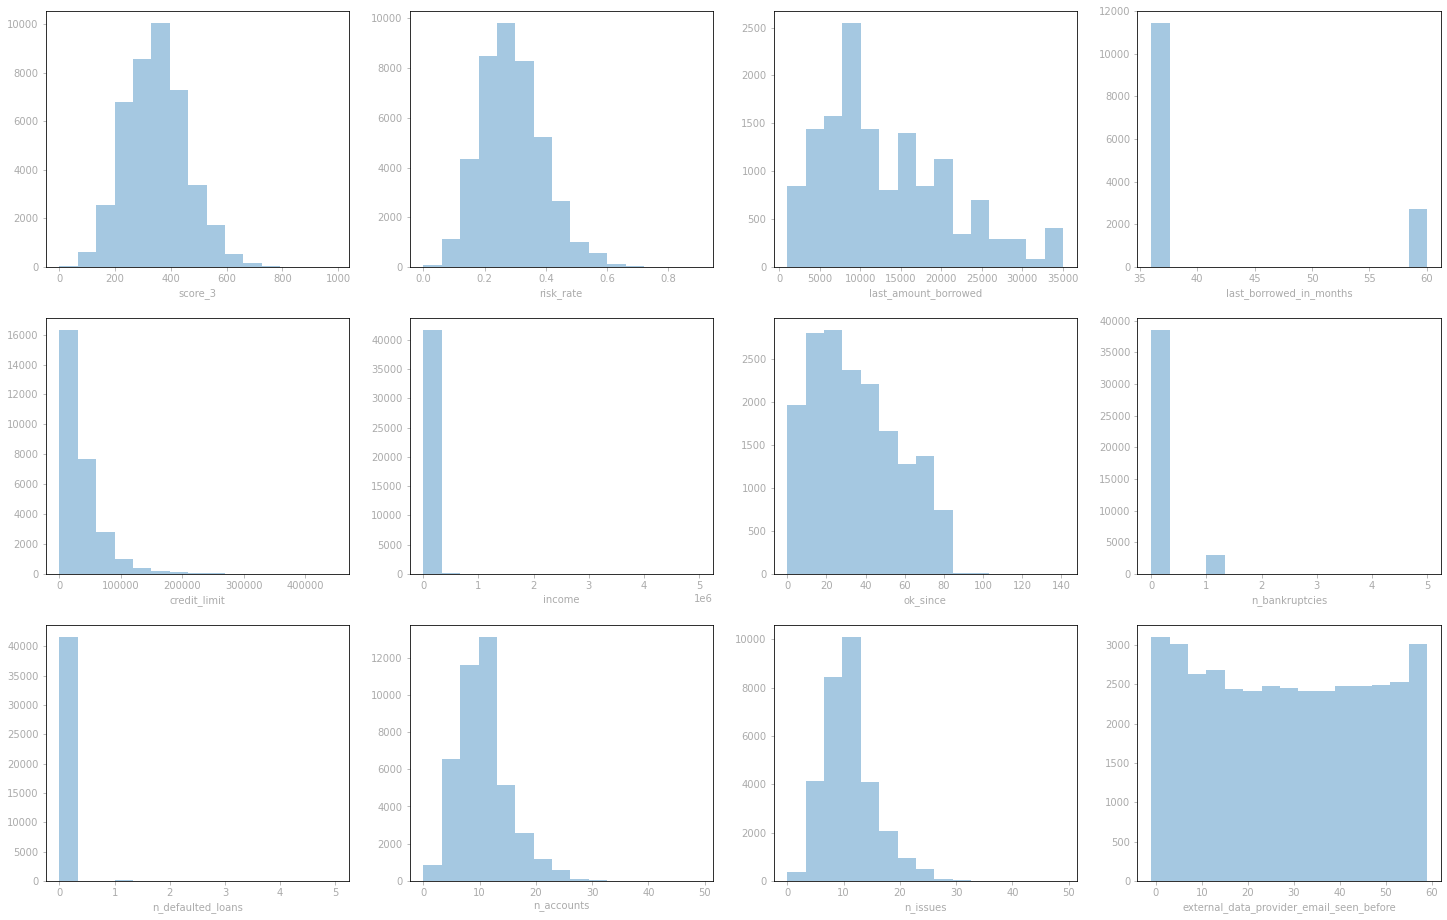

In [ ]:
# plot a histogram for each of the features above 

nrows = 3
ncols = 4

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 16))

r = 0
c = 0

for i in df_credit_numerical:
  sns.distplot(df_credit_numerical[i], bins=15,kde=False, ax=ax[r][c])
  if c == ncols - 1:
    r += 1
    c = 0
  else:
    c += 1

plt.show()

All these features above have missing values that need to be treated. As we can see, they have skewed distribution, which is an indication that we should fill the missing values with the median value for each feature.

It's time to deal with the missing values from the remaining 32 columns. We are filling these values according to the particularities of each feature, as below:



*   Categorical variables will be filled with the most recurrent value.
*   Numerical variables will be filled with their median values.
*   In the specific cases of `last_amount_borrowed`, `last_borrowed_in_months` and `n_issues` we'll fill the missing values with zero, as it is reasonable to believe that not every client would have values assigned to these variables.



In [ ]:
df_credit_num = df_credit.select_dtypes(exclude='object').columns
df_credit_cat = df_credit.select_dtypes(include='object').columns

# fill missing values for "last_amount_borrowed", "last_borrowed_in_months" and "n_issues"
df_credit['last_amount_borrowed'].fillna(value=0, inplace=True)
df_credit['last_borrowed_in_months'].fillna(value=0, inplace=True)
df_credit['n_issues'].fillna(value=0, inplace=True)

# fill missing values for numerical variables
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer = imputer.fit(df_credit.loc[:, df_credit_num])
df_credit.loc[:, df_credit_num] = imputer.transform(df_credit.loc[:, df_credit_num])

# fill missing values for categorical variables
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer = imputer.fit(df_credit.loc[:, df_credit_cat])
df_credit.loc[:, df_credit_cat] = imputer.transform(df_credit.loc[:, df_credit_cat])

In [ ]:
df_credit.isnull().sum()

target_default                                     0
score_1                                            0
score_2                                            0
score_3                                            0
score_4                                            0
score_5                                            0
score_6                                            0
risk_rate                                          0
last_amount_borrowed                               0
last_borrowed_in_months                            0
credit_limit                                       0
income                                             0
facebook_profile                                   0
state                                              0
real_state                                         0
ok_since                                           0
n_bankruptcies                                     0
n_defaulted_loans                                  0
n_accounts                                    

After handling the missing values, case by case, we now have a data set free of null values.

We'll now preprocess the data, converting the categorical features into numerical values. `LabelEncoder` will be used for the binary variables while `get_dummies` will be used for the other categorical variables.

In [ ]:
bin_var = df_credit.nunique()[df_credit.nunique() == 2].keys().tolist()
num_var = [col for col in df_credit.select_dtypes(['int', 'float']).columns.tolist() if col not in bin_var]
cat_var = [col for col in df_credit.select_dtypes(['object']).columns.tolist() if col not in bin_var]

df_credit_encoded = df_credit.copy()

# label encoding for the binary variables
le = LabelEncoder()
for col in bin_var:
  df_credit_encoded[col] = le.fit_transform(df_credit_encoded[col])

# encoding with get_dummies for the categorical variables
df_credit_encoded = pd.get_dummies(df_credit_encoded, columns=cat_var)

df_credit_encoded.head()

,target_default,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,facebook_profile,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,score_1_1Rk8w4Ucd5yR3KcqZzLdow==,score_1_4DLlLW62jReXaqbPaHp1vQ==,score_1_8k8UDR4Yx0qasAjkGrUZLw==,score_1_DGCQep2AE5QRkNCshIAlFQ==,score_1_e4NYDor1NOw6XKGE60AWFw==,score_1_fyrlulOiZ+5hoFqLa6UbDQ==,score_1_smzX0nxh5QlePvtVf6EAeg==,score_2_+2hzpeP1RWr8PEvL1WTUdw==,score_2_+CxEO4w7jv3QPI/BQbyqAA==,score_2_/tdlnWjXoZ3OjdtBXzdOJQ==,score_2_5/uMrqKj3OL/Xk5OrGx9fg==,score_2_55UK234RR1d7HIWJjmq9tw==,score_2_6J1ZMTzN5GKHXnhM4J1JbA==,score_2_7h+tk4z7O9brtBSe1rNjxA==,score_2_7h8PTkrlTWUPP3yuyP4rUg==,score_2_A+QuW1n/ABeiVVe/9CRZ9Q==,score_2_Fv28Bz0YRTVAT5kl1bAV6g==,score_2_IOVu8au3ISbo6+zmfnYwMg==,...,state_kfFcVGcsJmH2n3eYprLkeQ==,state_orU7WJYGPT/xFwOXY1eBkw==,state_qItmSqWrjm+MopDA+UpKRw==,state_rrVbgRNTRyB6auEycsRrpA==,state_sjJbkqJS7cXalHLBFA+EOQ==,state_umkEte5GXWggFkMOtKQ3Ug==,state_x6Gw/1I8t3KPgT6s82Kodg==,state_xsd3ZdsI3356I3xMxZeiqQ==,state_ygE7OTdsxRMLeXMa0EZwZw==,state_yni6lL4oSly97UVZeRSyxA==,real_state_+qWF9pJpVGtTFn4vFjb/cg==,real_state_N5/CE7lSkAfB04hVFFwllw==,real_state_UX7AdFYgQh+VrVC5eIaU9w==,real_state_n+xK9CfX0bCn77lClTWviw==,real_state_nSpvDsIsslUaX6GE6m6eQA==,shipping_state_BR-AC,shipping_state_BR-AL,shipping_state_BR-AM,shipping_state_BR-AP,shipping_state_BR-BA,shipping_state_BR-CE,shipping_state_BR-DF,shipping_state_BR-ES,shipping_state_BR-GO,shipping_state_BR-MA,shipping_state_BR-MG,shipping_state_BR-MS,shipping_state_BR-MT,shipping_state_BR-PA,shipping_state_BR-PB,shipping_state_BR-PE,shipping_state_BR-PR,shipping_state_BR-RN,shipping_state_BR-RO,shipping_state_BR-RR,shipping_state_BR-RS,shipping_state_BR-SC,shipping_state_BR-SE,shipping_state_BR-SP,shipping_state_BR-TO
0,0,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,65014.12,1,32.0,0.0,0.0,18.0,18.0,444.0,2.0,0,51.0,645.0,57849.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,370.0,97.062615,0.942655,92.002546,0.24,0.00,0.0,39726.0,100018.91,0,50.0,0.0,0.0,14.0,14.0,346.0,1.0,0,17.0,243.0,4902.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,25213.0,65023.65,0,32.0,0.0,0.0,10.0,0.0,6.0,2.0,1,9.0,65.0,163679.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,510.0,101.599485,0.987673,94.902491,0.32,0.00,0.0,54591.0,68830.01,0,32.0,1.0,0.0,19.0,19.0,406.0,3.0,1,38.0,815.0,1086.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,500.0,98.474289,0.532539,118.126207,0.18,0.00,0.0,25213.0,60011.29,1,32.0,0.0,0.0,11.0,0.0,240.0,2.0,1,46.0,320.0,198618.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


After encoding the categorical variables, let's start working on the machine learning models.

## Machine Learning Models

We are experimenting with the following 3 boosting algorithms to determine which one yields better results:


*   XGBoost
*   LightGBM
*   CatBoost

Before starting with the models, let's split the data into training and test sets.

In [ ]:
# feature matrix
X = df_credit_encoded.drop('target_default', axis=1)

# target vector
y = df_credit_encoded['target_default']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y)

Now, as we are dealing with an unbalanced data set, we'll standardize and resample the training set, with `StandardScaler` and `RandomUnderSampler`, respectively.

In [ ]:
# standardize numerical variables
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# resample
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

We're all set up to start evaluating the models. It's worth mentioning that we should consider `Precision`, `Recall` and `F1 Score` as evaluation metrics, for the following reasons:


*   **Precision** will give us the proportion of positive identifications that were indeed correct. It can be defined as:

${Precision} = \frac{True Positives}{True Positives + False Positives}$


*   **Recall** will determine the proportion of real positives that were 
correctly identified, and it can be defined as:

${Recall} = \frac{True Positives}{True Positives + False Negatives}$

*   **F1 Score** is a metric that is useful when we need to seek a balance between precision and recall. The formula is defined as:

${F_1} = 2 \times \frac{Precision \times Recall}{Precision + Recall}$


Since our objective is to minimize company loss, predicting the risk of client default, a good recall rate is desirable because we want to identify the maximum amount of clients that are indeed prone to stop paying their debts, thus, we are pursuing a small number of *False Negatives*.

Additionally, we also seek to minimize the number of False Positives because we don't want clients to be mistakenly identified as defaulters. Therefore, a good precision rate is also desirable.

However, there is always a tradeoff between precision and recall. For this article, we chose to give more emphasis to recall, using it as our evaluation metric. 

We'll use Cross-Validation to get better results. Instead of simply splitting the data into a train and test set, the cross_validate method splits our training data into k number of Folds, making better use of the data. In our case, we'll perform 5-fold cross-validation, as we let the default k value.

In [ ]:
# define the function val_model
def val_model(X, y, clf, show=True):
    """
    Apply cross-validation on the training set.

    # Arguments
        X: DataFrame containing the independent variables.
        y: Series containing the target vector.
        clf: Scikit-learn estimator instance.
        
    # Returns
        float, mean value of the cross-validation scores.
    """
    
    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if show == True:
        print(f'Recall: {scores.mean()}, {scores.std()}')
    
    return scores.mean()

In [ ]:
#evaluate the models
xgb = XGBClassifier()
lgb = LGBMClassifier()
cb = CatBoostClassifier()

model = []
recall = []

for clf in (xgb, lgb, cb):
    model.append(clf.__class__.__name__)
    recall.append(val_model(X_train_rus, y_train_rus, clf, show=False))

pd.DataFrame(data=recall, index=model, columns=['Recall'])

A saída de streaming foi truncada nas últimas 5000 linhas.
5:	learn: 0.6766031	total: 93.4ms	remaining: 15.5s
6:	learn: 0.6744241	total: 101ms	remaining: 14.3s
7:	learn: 0.6721765	total: 108ms	remaining: 13.4s
8:	learn: 0.6702457	total: 115ms	remaining: 12.6s
9:	learn: 0.6681527	total: 122ms	remaining: 12s
10:	learn: 0.6661466	total: 129ms	remaining: 11.6s
11:	learn: 0.6643063	total: 136ms	remaining: 11.2s
12:	learn: 0.6625519	total: 143ms	remaining: 10.9s
13:	learn: 0.6608213	total: 150ms	remaining: 10.6s
14:	learn: 0.6593619	total: 157ms	remaining: 10.3s
15:	learn: 0.6577092	total: 164ms	remaining: 10.1s
16:	learn: 0.6562553	total: 171ms	remaining: 9.9s
17:	learn: 0.6550841	total: 178ms	remaining: 9.72s
18:	learn: 0.6538765	total: 185ms	remaining: 9.57s
19:	learn: 0.6527047	total: 194ms	remaining: 9.52s
20:	learn: 0.6513253	total: 204ms	remaining: 9.51s
21:	learn: 0.6501324	total: 211ms	remaining: 9.38s
22:	learn: 0.6489885	total: 218ms	remaining: 9.27s
23:	learn: 0.6479283	total: 22

,Recall
XGBClassifier,0.662726
LGBMClassifier,0.647915
CatBoostClassifier,0.645911


Notice that all three models yielded similar results. We'll now tune some hyperparameters on the models to see if we can achieve higher score values. The method utilized here is `GridSearchCV`, which will search over specified parameter values for each estimator.

### XGBoost

Let's start by making some adjustments to the XGBoost estimator. XGBoost is known for being one of the most effective Machine Learning algorithms, due to its good performance on structured and tabular datasets on classification and regression predictive modeling problems. It is highly customizable and counts with a large range of hyperparameters to be tuned.

For the XGBoost model, we'll tune the following hyperparameters, according to [the official documentation](https://xgboost.readthedocs.io/en/latest/parameter.html):


*   `n_estimators` - The number of trees in the model
*   `max_depth` - Maximum depth of a tree
*   `min_child_weight` - Minimum sum of instance weight needed in a child
*   `gamma` - Minimum loss reduction required to make a further partition on a leaf node of the tree
*   `learning_rate` - Step size shrinkage used in the update to prevents overfitting

In [ ]:
# XGBoost
xgb = XGBClassifier()

# parameter to be searched
param_grid = {'n_estimators': range(0,1000,50)}

# find the best parameter   
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.6657327195142321 for {'n_estimators': 50}


In [ ]:
# XGBoost
xgb = XGBClassifier(n_estimators=50)

# parameter to be searched
param_grid = {'max_depth': [1, 3, 5],
              'min_child_weight': [1, 3, 6]}

# find the best parameter   
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.6701307550047045 for {'max_depth': 3, 'min_child_weight': 6}


In [ ]:
# XGBoost
xgb = XGBClassifier(n_estimators=50, max_depth=3, min_child_weight=6)

# parameter to be searched
param_grid = {'gamma': [0, 1, 5]}

# find the best parameter   
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.6719385652158761 for {'gamma': 1}


In [ ]:
# XGBoost
xgb = XGBClassifier(n_estimators=50, max_depth=3, min_child_weight=6, gamma=1)

# parameter to be searched
param_grid = {'learning_rate': [0.0001, 0.001, 0.01, 0.1]}

# find the best parameter
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.8170548699960465 for {'learning_rate': 0.0001}


### LightGBM

Now, turning to the LightGBM model, another tree-based learning algorithm, we are going to tune the following hyperparameters, referring to the [documentation](https://lightgbm.readthedocs.io/en/latest/Parameters.html):

*   `max_depth` - Maximum depth of a tree
*   `learning_rate` - Shrinkage rate
*   `num_leaves` - Max number of leaves in one tree
*   `min_data_in_leaf` - Minimal number of data in one leaf



In [ ]:
# LightGBM
lbg = LGBMClassifier(silent=False)

# parameter to be searched
param_grid = {"max_depth": np.arange(5, 75, 10),
              "learning_rate" : [0.001, 0.01, 0.1],
              "num_leaves": np.arange(20, 220, 50),
             }

# find the best parameter            
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(lbg, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.6883483723819858 for {'learning_rate': 0.01, 'max_depth': 5, 'num_leaves': 70}


In [ ]:
lbg = LGBMClassifier(learning_rate=0.01, max_depth=5, num_leaves=50, silent=False)

# parameter to be searched
param_grid = {'min_data_in_leaf': np.arange(100, 1000, 100)}

# find the best parameter            
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(lbg, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.6961582230489793 for {'min_data_in_leaf': 400}


### CatBoost

Lastly, we're going to search over hyperparameter values for CatBoost, our third gradient boosting algorithm. The following hyperparameters will be tuned, according to the [documentation](https://catboost.ai/docs/concepts/parameter-tuning.html):


*   `depth` - Depth of the tree
*   `learning_rate` - As we already know, the learning rate
*   `l2_leaf_reg` - Coefficient at the L2 regularization term of the cost function



In [ ]:
# CatBoost
cb = CatBoostClassifier()

# parameter to be searched
param_grid = {'depth': [6, 8, 10],
              'learning_rate': [0.03, 0.1],
              'l2_leaf_reg': [1, 5, 10],
             }

# find the best parameter            
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(cb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

0:	learn: 0.6895401	total: 9.95ms	remaining: 9.94s
1:	learn: 0.6860938	total: 18.7ms	remaining: 9.31s
2:	learn: 0.6829368	total: 26.7ms	remaining: 8.88s
3:	learn: 0.6798871	total: 34.4ms	remaining: 8.57s
4:	learn: 0.6772491	total: 42.5ms	remaining: 8.45s
5:	learn: 0.6746800	total: 50.1ms	remaining: 8.31s
6:	learn: 0.6724516	total: 58ms	remaining: 8.23s
7:	learn: 0.6698887	total: 65.7ms	remaining: 8.15s
8:	learn: 0.6678268	total: 73.6ms	remaining: 8.11s
9:	learn: 0.6655427	total: 81.2ms	remaining: 8.04s
10:	learn: 0.6636396	total: 88.8ms	remaining: 7.99s
11:	learn: 0.6617247	total: 96.7ms	remaining: 7.96s
12:	learn: 0.6599988	total: 104ms	remaining: 7.93s
13:	learn: 0.6582533	total: 112ms	remaining: 7.92s
14:	learn: 0.6568065	total: 120ms	remaining: 7.91s
15:	learn: 0.6549345	total: 128ms	remaining: 7.89s
16:	learn: 0.6535765	total: 136ms	remaining: 7.89s
17:	learn: 0.6524958	total: 144ms	remaining: 7.87s
18:	learn: 0.6513750	total: 152ms	remaining: 7.86s
19:	learn: 0.6501388	total: 160

After tuning some hyperparameters, all three models displayed betters results. It is worth mentioning that XGBoost presented a great score increase, while LightGBM and CatBoost saw a meager improvement.

Now, we can check how these models perform on the **test set**. To help us visualize the results, we are plotting a **confusion matrix**.

              precision    recall  f1-score   support

           0       0.92      0.44      0.60      8771
           1       0.22      0.81      0.34      1665

    accuracy                           0.50     10436
   macro avg       0.57      0.63      0.47     10436
weighted avg       0.81      0.50      0.56     10436



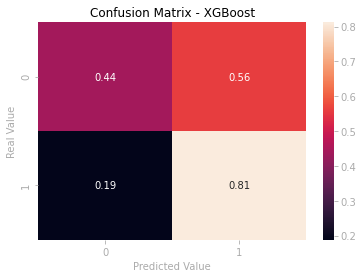

In [ ]:
# final XGBoost model
xgb = XGBClassifier(max_depth=3, learning_rate=0.0001, n_estimators=50, gamma=1, min_child_weight=6)
xgb.fit(X_train_rus, y_train_rus)

# prediction
X_test_xgb = scaler.transform(X_test)
y_pred_xgb = xgb.predict(X_test_xgb)

# classification report
print(classification_report(y_test, y_pred_xgb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_xgb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - XGBoost')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

              precision    recall  f1-score   support

           0       0.91      0.62      0.74      8771
           1       0.25      0.68      0.37      1665

    accuracy                           0.63     10436
   macro avg       0.58      0.65      0.55     10436
weighted avg       0.81      0.63      0.68     10436



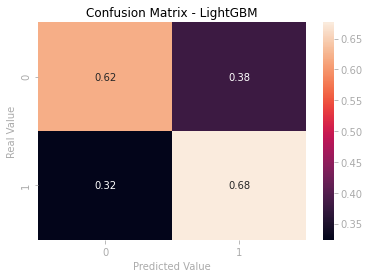

In [ ]:
# final LightGBM model
lgb = LGBMClassifier(num_leaves=70, max_depth=5, learning_rate=0.01, min_data_in_leaf=400)
lgb.fit(X_train_rus, y_train_rus)

# prediction
X_test_lgb = scaler.transform(X_test)
y_pred_lgb = lgb.predict(X_test_lgb)

# classification report
print(classification_report(y_test, y_pred_lgb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_lgb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - LightGBM')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

              precision    recall  f1-score   support

           0       0.91      0.67      0.77      8771
           1       0.27      0.64      0.38      1665

    accuracy                           0.66     10436
   macro avg       0.59      0.65      0.57     10436
weighted avg       0.81      0.66      0.71     10436



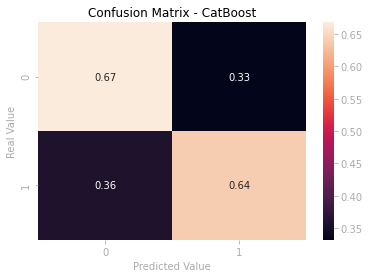

In [ ]:
# final CatBoost model
cb = CatBoostClassifier(learning_rate=0.03, depth=6, l2_leaf_reg=5, logging_level='Silent')
cb.fit(X_train_rus, y_train_rus)

# prediction
X_test_cb = scaler.transform(X_test)
y_pred_cb = cb.predict(X_test_cb)

# classification report
print(classification_report(y_test, y_pred_cb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_cb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - CatBoost')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

## Conclusion

The main objective of this article was to build a machine learning algorithm that would be able to identify potential defaulters and therefore reduce company loss. The best model possible would be the one that could minimize false negatives, identifying all defaulters among the client base, while also minimizing false positives, preventing clients to be wrongly classified as defaulters.

Meeting these requirements can be quite tricky as there is a tradeoff between precision and recall, meaning that increasing the value of one of these metrics often decreases the value of the other. Considering the importance of minimizing company loss, we decided to give more emphasis on reducing false positives, searching for the best hyperparameters that could increase the recall rate.

Among the three **Gradient Boosting Algorithms** tested, **XGBoost** yielded the best results, with a recall rate of 81%, although it delivered an undesired 56% of false positives. On the other hand, **LightGBM** and **CatBoost** delivered a better count of false positives, with 38% and 33% respectively, but their false negatives were substantially higher than that of XGBoost, resulting in a weaker recall rate.

This article presents a classic evaluation metrics dilemma. In this case, it would be up to the company's decision-makers to analyze the big picture, with the aid of the machine learning algorithms, and decide the best plan to follow. Of course, in a future article, we can test a different approach to achieve a more desirable result, such as taking advantage of deep learning models.